In [1]:
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/My Drive/AIML Project/preprocessed_balanced_ham10000_500.csv')

Mounted at /content/drive


In [2]:

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    silhouette_score,
    adjusted_rand_score,
    davies_bouldin_score,
    calinski_harabasz_score,
    homogeneity_score,
    completeness_score,
    v_measure_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)
from sklearn.model_selection import train_test_split
from itertools import product
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt


In [3]:
# --- Load dataset ---
df = pd.read_csv('/content/drive/My Drive/AIML Project/preprocessed_balanced_ham10000_500.csv')

# --- Feature selection ---
features = ['age', 'sex', 'localization']
X = df[features]

# --- Preprocess categorical features ---
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), ['sex', 'localization'])
    ],
    remainder='passthrough'
)
X_preprocessed = preprocessor.fit_transform(X)
y_true = df['dx_encoded']

print("Data loaded and preprocessed successfully!")
print("Shape of processed data:", X_preprocessed.shape)



Data loaded and preprocessed successfully!
Shape of processed data: (3500, 16)


In [4]:
# --- Parameter grid for hyperparameter tuning ---
param_grid = {
    'n_clusters': range(2, 11),
    'init': ['k-means++', 'random'],
    'n_init': [10, 20],
    'max_iter': [300, 500],
    'algorithm': ['lloyd', 'elkan']
}

# --- Helper function: match cluster labels to true labels ---
def match_labels(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    row_ind, col_ind = linear_sum_assignment(-cm)  # maximize accuracy
    mapping = {col: row for row, col in zip(row_ind, col_ind)}
    y_mapped = np.array([mapping[label] for label in y_pred])
    return y_mapped

print("Parameter grid and helper functions defined.")


Parameter grid and helper functions defined.


In [5]:
results = []

for n_clusters, init, n_init, max_iter, algorithm in product(
    param_grid['n_clusters'],
    param_grid['init'],
    param_grid['n_init'],
    param_grid['max_iter'],
    param_grid['algorithm']
):
    try:
        # --- KMeans training ---
        kmeans = KMeans(
            n_clusters=n_clusters,
            init=init,
            n_init=n_init,
            max_iter=max_iter,
            algorithm=algorithm,
            random_state=42
        )
        cluster_labels = kmeans.fit_predict(X_preprocessed)

        # Convert X_preprocessed to a dense array for metrics that require it
        X_preprocessed_dense = X_preprocessed.toarray() if hasattr(X_preprocessed, 'toarray') else X_preprocessed

        # --- Internal metrics ---
        sil = silhouette_score(X_preprocessed_dense, cluster_labels)
        db = davies_bouldin_score(X_preprocessed_dense, cluster_labels)
        ch = calinski_harabasz_score(X_preprocessed_dense, cluster_labels)

        # --- External metrics ---
        ari = adjusted_rand_score(y_true, cluster_labels)
        homo = homogeneity_score(y_true, cluster_labels)
        comp = completeness_score(y_true, cluster_labels)
        vmeasure = v_measure_score(y_true, cluster_labels)

        # --- Classification metrics (after label matching) ---
        mapped_labels = match_labels(y_true, cluster_labels)
        acc = accuracy_score(y_true, mapped_labels)
        prec = precision_score(y_true, mapped_labels, average='weighted', zero_division=0)
        rec = recall_score(y_true, mapped_labels, average='weighted', zero_division=0)
        f1 = f1_score(y_true, mapped_labels, average='weighted', zero_division=0)

        # --- Validation (train-test split) ---
        X_train, X_test, y_train, y_test = train_test_split(X_preprocessed_dense, y_true, test_size=0.2, random_state=42)
        kmeans_train = KMeans(
            n_clusters=n_clusters,
            init=init,
            n_init=n_init,
            max_iter=max_iter,
            algorithm=algorithm,
            random_state=42
        ).fit(X_train)
        test_labels = kmeans_train.predict(X_test)
        test_sil = silhouette_score(X_test, test_labels)

        # --- Store results ---
        results.append({
            'n_clusters': n_clusters,
            'init': init,
            'n_init': n_init,
            'max_iter': max_iter,
            'algorithm': algorithm,
            'silhouette_score': sil,
            'davies_bouldin': db,
            'calinski_harabasz': ch,
            'ari': ari,
            'homogeneity': homo,
            'completeness': comp,
            'v_measure': vmeasure,
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1_score': f1,
            'test_silhouette': test_sil
        })

    except Exception as e:
        print(f"Error with params: {n_clusters}, {init}, {n_init}, {max_iter}, {algorithm}")
        print(e)
        continue

print("Hyperparameter tuning completed successfully!")

Hyperparameter tuning completed successfully!


In [6]:
# --- Convert to DataFrame ---
results_df = pd.DataFrame(results)
print("Total combinations evaluated:", len(results_df))

# --- Sort by F1 score (or change to silhouette_score if preferred) ---
best_params = results_df.sort_values(by='f1_score', ascending=False).iloc[0]
print("\nBest Parameters Based on F1 Score:")
print(best_params)

# --- Save results ---
results_df.to_csv('kmeans_hyperparameter_tuning_results_new.csv', index=False)
print("\nAll results saved to 'kmeans_hyperparameter_tuning_results_new.csv'")

# --- Optional quick check ---
results_df.head()


Total combinations evaluated: 144

Best Parameters Based on F1 Score:
n_clusters                      9
init                       random
n_init                         10
max_iter                      300
algorithm                   lloyd
silhouette_score         0.613024
davies_bouldin           0.492086
calinski_harabasz    16659.460493
ari                      0.037743
homogeneity              0.075766
completeness             0.069722
v_measure                0.072618
accuracy                    0.214
precision                 0.28632
recall                      0.214
f1_score                 0.230063
test_silhouette          0.618968
Name: 120, dtype: object

All results saved to 'kmeans_hyperparameter_tuning_results_new.csv'


,n_clusters,init,n_init,max_iter,algorithm,silhouette_score,davies_bouldin,calinski_harabasz,ari,homogeneity,completeness,v_measure,accuracy,precision,recall,f1_score,test_silhouette
0,2,k-means++,10,300,lloyd,0.587296,0.569342,7253.758255,0.048447,0.046992,0.132874,0.06943,0.226571,0.065389,0.226571,0.101314,0.584461
1,2,k-means++,10,300,elkan,0.587296,0.569342,7253.758255,0.048447,0.046992,0.132874,0.06943,0.226571,0.065389,0.226571,0.101314,0.584461
2,2,k-means++,10,500,lloyd,0.587296,0.569342,7253.758255,0.048447,0.046992,0.132874,0.06943,0.226571,0.065389,0.226571,0.101314,0.584461
3,2,k-means++,10,500,elkan,0.587296,0.569342,7253.758255,0.048447,0.046992,0.132874,0.06943,0.226571,0.065389,0.226571,0.101314,0.584461
4,2,k-means++,20,300,lloyd,0.587296,0.569342,7253.758255,0.048447,0.046992,0.132874,0.06943,0.226571,0.065389,0.226571,0.101314,0.584461


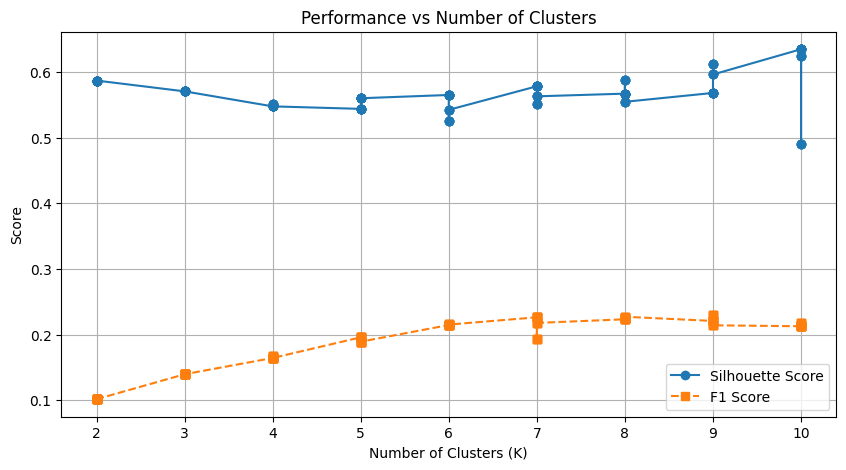

In [7]:
plt.figure(figsize=(10, 5))
plt.plot(results_df['n_clusters'], results_df['silhouette_score'], 'o-', label='Silhouette Score')
plt.plot(results_df['n_clusters'], results_df['f1_score'], 's--', label='F1 Score')
plt.title('Performance vs Number of Clusters')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()


In [8]:
final_kmeans = KMeans(
    n_clusters=int(best_params['n_clusters']),
    init=best_params['init'],
    n_init=int(best_params['n_init']),
    max_iter=int(best_params['max_iter']),
    algorithm=best_params['algorithm'],
    random_state=42
)

final_labels = final_kmeans.fit_predict(X_preprocessed)
final_labels_mapped = match_labels(y_true, final_labels)

final_sil = silhouette_score(X_preprocessed, final_labels)
final_ari = adjusted_rand_score(y_true, final_labels)
final_acc = accuracy_score(y_true, final_labels_mapped)
final_prec = precision_score(y_true, final_labels_mapped, average='weighted', zero_division=0)
final_rec = recall_score(y_true, final_labels_mapped, average='weighted', zero_division=0)
final_f1 = f1_score(y_true, final_labels_mapped, average='weighted', zero_division=0)

print("\n📊 Final Model Evaluation Metrics:")
print(f"Silhouette Score: {final_sil:.4f}")
print(f"Adjusted Rand Index: {final_ari:.4f}")
print(f"Accuracy: {final_acc:.4f}")
print(f"Precision: {final_prec:.4f}")
print(f"Recall: {final_rec:.4f}")
print(f"F1 Score: {final_f1:.4f}")



📊 Final Model Evaluation Metrics:
Silhouette Score: 0.6130
Adjusted Rand Index: 0.0377
Accuracy: 0.2140
Precision: 0.2863
Recall: 0.2140
F1 Score: 0.2301


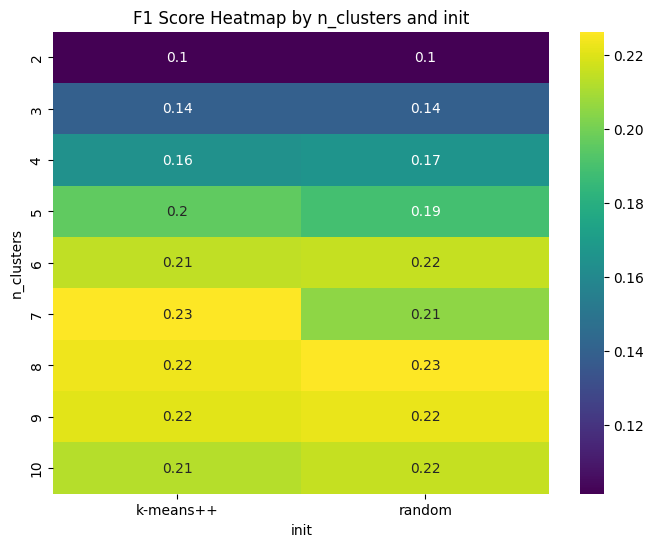

In [9]:
import seaborn as sns
pivot = results_df.pivot_table(values='f1_score', index='n_clusters', columns='init')
plt.figure(figsize=(8, 6))
sns.heatmap(pivot, annot=True, cmap='viridis')
plt.title('F1 Score Heatmap by n_clusters and init')
plt.show()


In [11]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from scipy.optimize import linear_sum_assignment

# --- Helper function to match predicted cluster labels to true labels ---
def match_labels(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    row_ind, col_ind = linear_sum_assignment(-cm)  # maximize accuracy
    mapping = {col: row for row, col in zip(row_ind, col_ind)}
    y_mapped = np.array([mapping[label] for label in y_pred])
    return y_mapped

# --- Split dataset into train, validation, and test ---
# 60% train, 20% validation, 20% test
X_train, X_temp, y_train, y_temp = train_test_split(X_preprocessed, y_true, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# --- Train final KMeans model (use your chosen/best parameters here) ---
final_kmeans = KMeans(
    n_clusters=int(best_params['n_clusters']),
    init=best_params['init'],
    n_init=int(best_params['n_init']),
    max_iter=int(best_params['max_iter']),
    algorithm=best_params['algorithm'],
    random_state=42
)
final_kmeans.fit(X_train)

# --- Predict clusters for train, val, and test sets ---
train_labels = final_kmeans.predict(X_train)
val_labels = final_kmeans.predict(X_val)
test_labels = final_kmeans.predict(X_test)

# --- Match predicted cluster labels to actual labels ---
train_mapped = match_labels(y_train, train_labels)
val_mapped = match_labels(y_val, val_labels)
test_mapped = match_labels(y_test, test_labels)

# --- Compute accuracies ---
train_acc = accuracy_score(y_train, train_mapped) * 100
val_acc = accuracy_score(y_val, val_mapped) * 100
test_acc = accuracy_score(y_test, test_mapped) * 100

# --- Display results ---
print("📊 K-Means Model Accuracy Results:")
print(f"Training Accuracy:   {train_acc:.2f}%")
print(f"Validation Accuracy: {val_acc:.2f}%")
print(f"Test Accuracy:       {test_acc:.2f}%")

📊 K-Means Model Accuracy Results:
Training Accuracy:   21.10%
Validation Accuracy: 21.86%
Test Accuracy:       24.29%
